In [ ]:
import sys
from pathlib import Path
import os

%cd ./nanovlm-lab/
project_root = Path.cwd()

nanovlm_root = project_root / "nanovlm"

# Add paths in the correct order
if str(nanovlm_root) not in sys.path:
    sys.path.insert(0, str(nanovlm_root))  # Add nanoVLM FIRST
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))  # Then add project root

# Change working directory to nanovlm so relative imports work
os.chdir(nanovlm_root)

print(f"Project root: {project_root}")
print(f"NanoVLM root: {nanovlm_root}")
print(f"Current directory: {os.getcwd()}")

/workspace/RL-VLM-Lab
Project root: /workspace/RL-VLM-Lab
NanoVLM root: /workspace/RL-VLM-Lab/nanovlm
Current directory: /workspace/RL-VLM-Lab/nanovlm


In [2]:
from nanovlm.data.datasets import VQADataset
from nanovlm.data.collators import VQACollator
from nanovlm.data.data_utils import synchronized_dataloader_step
from nanovlm.data.advanced_datasets import ConstantLengthDataset
from nanovlm.data.processors import get_image_processor, get_tokenizer

import nanovlm.models.config as config
from nanovlm.models.vision_language_model import VisionLanguageModel

# Libraries
import math
import time
import torch
from tqdm import tqdm
import torch.optim as optim
import matplotlib.pyplot as plt
from dataclasses import dataclass, field
from torch.utils.data import DataLoader
from datasets import load_dataset, concatenate_datasets, get_dataset_config_names

#Otherwise, the tokenizer will throw a warning
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

if torch.cuda.is_available():
    device = "cuda"
elif hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"
print(f"Using device: {device}")

torch.manual_seed(0)
torch.cuda.manual_seed_all(0)

# To reload the modules if you change something in the code
%reload_ext autoreload
%autoreload 2

Using device: cuda


In [3]:
from datasets import load_dataset

dataset_id = "HuggingFaceH4/rlaif-v_formatted"
train_dataset = load_dataset("LYM2024/RLAIF-V-Dataset_subset",split="train")
test_dataset = load_dataset("LYM2024/RLAIF-V-Dataset_subset",split="test")

from PIL import Image

def ensure_rgb(example):
    # Convert the image to RGB if it's not already
    image = example['image']
    if isinstance(image, Image.Image):
        if image.mode != 'RGB':
            image = image.convert('RGB')
        example['image'] = image
    return example

# Apply the transformation to the dataset
train_dataset = train_dataset.map(ensure_rgb, num_proc=4)
test_dataset = test_dataset.map(ensure_rgb, num_proc=4)

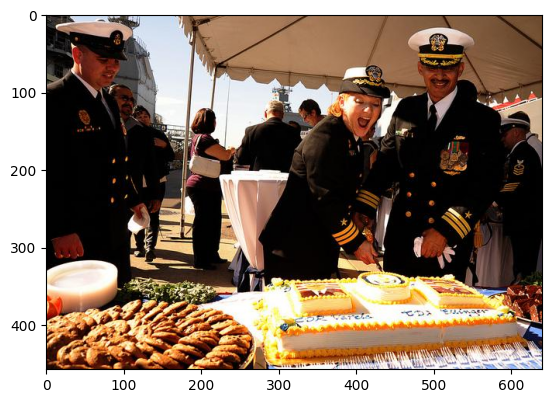

In [4]:
import matplotlib.pyplot as plt
plt.imshow(train_dataset[0]['image'])

In [5]:
train_dataset = train_dataset.rename_column("question","prompt")
test_dataset = test_dataset.rename_column("question","prompt")

In [7]:
from nanovlm.data.processors import get_tokenizer, get_image_processor
from nanovlm.models.vision_language_model import VisionLanguageModel
from rlvlm.nanovlm_dpo_trainer import NanoVLMDPOTrainer, create_nanovlm_dpo_dataset
from datasets import load_dataset
from peft import LoraConfig, get_peft_model

# Load model
model = VisionLanguageModel.from_pretrained("lusxvr/nanoVLM-230M-8k")

# Get processors
tokenizer = get_tokenizer(model.cfg.lm_tokenizer, model.cfg.vlm_extra_tokens, model.cfg.lm_chat_template)
image_processor = get_image_processor(model.cfg.max_img_size, model.cfg.vit_img_size, model.cfg.resize_to_max_side_len)
peft_config = LoraConfig(
    r=16,
    lora_alpha=16,
    lora_dropout=0.1,
    target_modules=['down_proj','o_proj','k_proj','q_proj','gate_proj','up_proj','v_proj'],
    use_dora=False,
    init_lora_weights="gaussian"
)
peft_model = get_peft_model(model, peft_config)
peft_model.print_trainable_parameters()


Resize to max side len: True
trainable params: 4,331,520 || all params: 232,395,456 || trainable%: 1.8639


In [8]:
preference_dataset = create_nanovlm_dpo_dataset(
    dataset=train_dataset,  # HuggingFace dataset with: image, prompt, chosen, rejected
    image_processor=image_processor,
    tokenizer=tokenizer,
    model_cfg=model.cfg,
    max_prompt_length=None,
    max_completion_length=1024,
)
preference_dataset_test = create_nanovlm_dpo_dataset(
    dataset=test_dataset,  # HuggingFace dataset with: image, prompt, chosen, rejected
    image_processor=image_processor,
    tokenizer=tokenizer,
    model_cfg=model.cfg,
    max_prompt_length=None,
    max_completion_length=1024,
)

In [9]:
from trl import DPOConfig

training_args = DPOConfig(
    output_dir="nanovlm-instruct-trl-dpo-rlaif-v",
    bf16=True,
    gradient_checkpointing=False,
    per_device_train_batch_size=1,
    per_device_eval_batch_size=1,
    gradient_accumulation_steps=4,
    num_train_epochs=3,
    dataset_num_proc=8,  # tokenization will use 8 processes
    dataloader_num_workers=8,  # data loading will use 8 workers
    logging_steps=5,
    eval_strategy="steps",
    eval_steps=5,
    push_to_hub=False,
)

In [10]:
trainer = NanoVLMDPOTrainer(
    model=peft_model,
    ref_model=None,  # Will create a copy of the model
    args=training_args,
    train_dataset=preference_dataset,
    eval_dataset=preference_dataset_test,
    tokenizer=tokenizer,
    image_processor=image_processor,
    beta=0.1,
    loss_type="sigmoid",
    max_length=2048
)

In [ ]:
trainer.train()

In [13]:
trainer.save_model(training_args.output_dir)

Saving LoRA adapters to nanovlm-instruct-trl-dpo-rlaif-v


In [ ]:
import argparse
import torch
from PIL import Image
from peft import PeftModel

from models.vision_language_model import VisionLanguageModel
from data.processors import get_tokenizer, get_image_processor, get_image_string
torch.manual_seed(0)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(0)
    device = torch.device("cuda")
elif hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"Using device: {device}")

source = "./nanovlm-instruct-trl-dpo-rlaif-v"
print(f"Loading weights from: {source}")

# 1. Load the base model
base_model = VisionLanguageModel.from_pretrained("lusxvr/nanoVLM-230M-8k").to(device)

# 2. Load LoRA adapters on top
model = PeftModel.from_pretrained(
    base_model,
    source,  # Your output_dir with adapter_config.json
)

# 3. Get tokenizer and image processor
tokenizer = get_tokenizer(model.cfg.lm_tokenizer, model.cfg.vlm_extra_tokens, model.cfg.lm_chat_template)
image_processor = get_image_processor(model.cfg.max_img_size, model.cfg.vit_img_size, False)

# 4. Set to eval mode
model.eval()
# Now you can use model for inference!

In [14]:
# Process image
image = train_dataset[0]['image']
prompt = train_dataset[0]['prompt']
processed_image, image_ratio = image_processor(image)

# Create message with image tokens
image_string = get_image_string(tokenizer, [image_ratio], model.cfg.mp_image_token_length)
messages = [{"role": "user", "content": image_string + prompt}]

# Tokenize
input_ids = tokenizer.apply_chat_template(
    messages,
    tokenize=True,
    add_generation_prompt=True,
    return_tensors="pt"
).to(device)

# Generate
with torch.no_grad():
    output_ids = model.generate(
        input_ids=input_ids,
        images=[processed_image],  # Pass as list
        max_new_tokens=1024,
        temperature=0.7,
        top_p=0.9,
    )

# Decode output
response = tokenizer.decode(output_ids[0], skip_special_tokens=True)
print(response)

Cakes are usually eaten at parties to celebrate and to commemorate special occasions, such as birthdays, anniversaries, or holidays. The festive atmosphere and shared enjoyment create the ideal setting for cakes to be a highlight of the event.
